In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Reference: https://github.com/rrwiyatn/robotik/blob/main/kalman_filter/kalman_filter.ipynb

**Assumptions used in Kalman filter:**
1. Linear dynamics with Gaussian noise $\mathbf{x}_{t} = A \mathbf{x}_{t-1} + B \mathbf{u}_{t-1} + \mathbf{w}_{t}$ where $\mathbf{w}_{t} \sim \mathcal{N}(0, Q)$
2. Linear measurement model with Gaussian noise $\mathbf{z}_t = H \mathbf{x}_t + \mathbf{n}_t$ where $\mathbf{n}_t \sim \mathcal{N}(0, R)$
3. Gaussian prior $bel(\mathbf{x}_0) \sim \mathcal{N}(\mu_0, \Sigma_0)$

In Kalman filter, there are two main steps that we need to perform. These are the prediction and update steps. We perform the prediction step to compute our new belief state after we apply a control signal $u_t$ to our robot following the motion model. After we apply a control signal $u_t$, we assume to have received a sensor measurement $z_t$, and we perform the update step to update the belief state based on the sensor measurement.

State = $\mathbf{x}_{t}$ = [x , y] i,e only positions <br/>
Measurement = $\mathbf{z}_{t}$ = [x, y] i,e only positions <br/>
Action = $\mathbf{u}_{t}$ = [$v_{x}$, $v_{y}$] i,e only velocity in x and y direction (we are seperating action from state matrix)

***Prediction step:***
1. $\mu_{t|t-1} = A\mu_{t-1|t-1} + B\mathbf{u}_{t-1}$
2. $\Sigma_{t|t-1} = A\Sigma_{t-1|t-1}A^T + Q$

***Correction step:***
1. Get measurement $\mathbf{z}_{t}$
2. Compute mean and covariance of the prediction residual $\delta_{\mu} = \mathbf{z}_{t} - H\mu_{t|t-1}$ and $\delta_{\Sigma} = H \Sigma_{t|t-1} H^T + R$
3. Compute Kalman gain $K_{t} = \Sigma_{t|t-1} H^T \delta_{\Sigma}^{-1}$
4. Compute mean and covariance of the belief $\mu_{t | t} = \mu_{t | t-1} + K\delta_{\mu}$ and $\Sigma_{t | t} = \Sigma_{t|t-1} - KH\Sigma_{t|t-1}$

**Example: estimating robot position with KF**

We have a robot moving in a room without obstacles that is equipped with sensors to measure distance between the robot and the walls, which allows the robot to measure the location of the robot  in the room (i.e., its $x$ and $y$ coordinates). For simplicity, let's assume we have a sensor that directly measure the $(x,y)$ location of the robot in the room. These sensors are not perfect, but we know how innacurate these sensors are (i.e., we know the measurement model). In addition, we also know the motion model of the robot. This means that we know the $A$, $B$, $Q$, $H$, and $R$ matrices:

$$
A = 
\begin{bmatrix}
1 & 0 \\
0 & 1
\end{bmatrix}
$$

$$
B = 
\begin{bmatrix}
1 & 0 \\
0 & 1
\end{bmatrix}
$$

$$
Q = 
\begin{bmatrix}
0.3 & 0 \\
0 & 0.3
\end{bmatrix}
$$

$$
H = 
\begin{bmatrix}
1 & 0 \\
0 & 1
\end{bmatrix}
$$

$$
R = 
\begin{bmatrix}
0.35 & 0.0 \\
0.0 & 0.3
\end{bmatrix}
$$

The state of the robot is its $x$ and $y$ position in the room, and the control inputs are the velocity in each direction $v_x$ and $v_y$. The robot is initialized at $(x,y) = (0,0)$, and moves by applying constant control inputs $v_x = v_y = 1$ for 10 time steps. Assume the initial belief state as the following:

$$
\mu_0 = 
\begin{bmatrix}
0 \\
0
\end{bmatrix}
$$

$$
\Sigma_0 = 
\begin{bmatrix}
0.1 & 0\\
0 & 0.1
\end{bmatrix}
$$

**Understanding the problem**

To understand the problem and motivate our desire to use Kalman filter, let's plot and compare the ideal trajectory with motion model trajectory as well as some possible measurements that we would get using the available sensors according to their specifications. Since we are not using an actual robot with a sensor, we will simulate the sensor measurements using the measurement model.

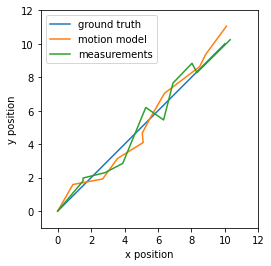

In [10]:
num_steps = 10

# state = [x_pos, y_pos]
ground_truth_xs = np.linspace(0, 10, num=num_steps + 1) # [0, 1, ..., 10]
ground_truth_ys = ground_truth_xs.copy() # x = y
ground_truth_states = np.stack((ground_truth_xs,ground_truth_ys), axis=1) # ground_truth_states is [[0,0], [1,1], ..., [10,10]]

# Simulate motion with our noisy motion model
x_0, y_0 = 0.0, 0.0
motion_states = [np.array([x_0, y_0])]
u_t = np.array([1.0, 1.0])
A = np.array([[1, 0],
              [0, 1]])
B = np.array([[1, 0],
              [0, 1]])
Q = np.array([[0.3, 0],
              [0, 0.3]]) # given Q matrix

for i in range(num_steps):
    motion_noise = np.random.multivariate_normal(mean=np.array([0,0]), cov=Q) # ~N(0,Q)
    new_state = A @ motion_states[-1] + B @ u_t + motion_noise # a @ b = np.dot(a,b)
    motion_states.append(new_state)
    
# Simulate measurements with our noisy measurement model
measurement_states = [np.array([x_0, y_0])]
H = np.array([[1, 0],
              [0, 1]]) # given H matrix
R = np.array([[0.35, 0],
              [0, 0.3]]) # given R matrix

for i in range(num_steps):
    measurement_noise = np.random.multivariate_normal(mean=np.array([0,0]), cov=R) # ~N(0,R)
    new_measurement = H @ ground_truth_states[i+1] + measurement_noise
    measurement_states.append(new_measurement)
    
# Convert motion_states and measurement_states to array so we can plot them easily
motion_states = np.array(motion_states)
measurement_states = np.array(measurement_states)

# Compare ground truth and measurements
plt.plot(ground_truth_states[:,0], ground_truth_states[:,1])
plt.plot(motion_states[:,0], motion_states[:,1])
plt.plot(measurement_states[:,0], measurement_states[:,1])
plt.xlim(-1,12)
plt.ylim(-1,12)
plt.xlabel('x position')
plt.ylabel('y position')
plt.legend(['ground truth', 'motion model', 'measurements'])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [13]:
def predict(A, B, Q, mu_t, sigma_t, u_t):
    mu_pred = A @ mu_t + B @ u_t
    sigma_pred = A @ sigma_t @ A.T + Q
    return mu_pred, sigma_pred

In [19]:
def correct(H, R, z_t, mu_pred, sigma_pred):
    residual_mean = z_t - H @ mu_pred
    residual_covariance = H @ sigma_pred @ H.T + R
    kalman_gain = sigma_pred @ H.T @ np.linalg.inv(residual_covariance)
    mu_corrected = mu_pred + kalman_gain @ residual_mean
    sigma_corrected = kalman_gain @ H @ sigma_pred
    return mu_corrected, sigma_corrected

In [20]:
# Re-initialize the problem with the given information
mu_0 = np.array([0, 0])
sigma_0 = np.array([[0.1, 0],[0, 0.1]])
u_t = np.array([1.0, 1.0])

u_t = np.array([1, 1]) # we assume constant control input

A = np.array([[1, 0],
              [0, 1]])
B = np.array([[1, 0],
              [0, 1]])
Q = np.array([[0.3, 0],
              [0, 0.3]])
H = np.array([[1, 0],
              [0, 1]])
R = np.array([[0.75, 0],
              [0, 0.6]])

measurement_states = []
filtered_states = []

mu_current = mu_0.copy()
sigma_current = sigma_0.copy()

for i in range(num_steps):
    mu_pred, sigma_pred = predict(A, B, Q, mu_current, sigma_current, u_t)
    
    measurement_noise = np.random.multivariate_normal(mean=np.array([0,0]), cov=R) # ~N(0,R)
    z_t = H @ ground_truth_states[i+1] + measurement_noise
    
    mu_current, sigma_current = correct(H, R, z_t, mu_pred, sigma_pred)
    
    measurement_states.append(z_t)
    filtered_states.append(mu_current)

# For plotting purposes, convert the lists to array
measurement_states = np.array(measurement_states)
filtered_states = np.array(filtered_states) 

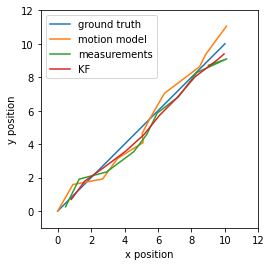

In [21]:
# Let's plot the results

plt.plot(ground_truth_states[:,0], ground_truth_states[:,1]) # from previous section
plt.plot(motion_states[:,0], motion_states[:,1]) # from previous section
plt.plot(measurement_states[:,0], measurement_states[:,1])
plt.plot(filtered_states[:,0], filtered_states[:,1])
plt.xlim(-1,12)
plt.ylim(-1,12)
plt.xlabel('x position')
plt.ylabel('y position')
plt.legend(['ground truth', 'motion model', 'measurements', 'KF'])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()